In [1]:
!pip uninstall --quiet -y torch torchaudio torchdata torchtext torchvision fastai
!pip install --quiet torch==1.12.1+cu113 -f https://download.pytorch.org/whl/torch_stable.html
!pip install --quiet ase==3.21.*
!pip install --quiet --no-index torch-scatter torch-sparse torch-cluster -f https://data.pyg.org/whl/torch-1.12.0+cu113.html
!pip install --quiet torch-geometric -f https://data.pyg.org/whl/torch-1.12.0+cu113.html
!git clone https://github.com/Fung-Lab/ActiveStructOpt.git
%cd ActiveStructOpt
!pip install --quiet -r requirements.txt
!pip install --quiet -e .
!git clone https://github.com/Fung-Lab/MatDeepLearn_dev
%cd MatDeepLearn_dev
!pip install -e .
%cd ..
!cp activestructopt/gnn/config.yml MatDeepLearn_dev/configs/

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 GB 819.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 7.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Cloning into 'ActiveStructOpt'...
remote: Enumerating objects: 344, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 344 (delta 42), reused 46 (delta 12), pack-reused 248
Receiving objects: 100% (344/344), 806.53 KiB | 3.00 MiB/s, done.
Resolving deltas: 100% (173/173), done.
/content/ActiveStructOpt
     ━━━━━━━━━━━━━━━━━━

In [2]:
import activestructopt.dataset.materialsproject
import activestructopt.dataset.rdf
import activestructopt.optimization.nlopt.nlopt
from pymatgen.core.composition import Composition
import numpy as np
import matplotlib.pyplot as plt
from pymatgen.io.ase import AseAtomsAdaptor
import json
import pandas as pd
import os
import torch
torch.cuda.is_available()

True

In [3]:
target_structure = activestructopt.dataset.materialsproject.get_structure('mp-22526', 'YOUR_API_KEY_HERE')

In [4]:
N = 100
initial_structures = [target_structure.copy() for i in range(N)]
for i in range(N):
  initial_structures[i].perturb(0.5)

In [5]:
data_list=[]
adaptor = AseAtomsAdaptor()
for i in range(N):
    ase_crystal = adaptor.get_atoms(initial_structures[i])
    positions = ase_crystal.get_positions().tolist()
    cell = ase_crystal.get_cell().tolist()
    atomic_numbers = ase_crystal.get_atomic_numbers().tolist()

    data_dict = {
        'structure_id': str(i),
        'positions': positions,
        'cell': cell,
        'atomic_numbers': atomic_numbers,
        'y': activestructopt.dataset.rdf.get_rdf(initial_structures[i], σ = 0.1).tolist(),
    }
    data_list.append(data_dict)

with open('./MatDeepLearn_dev/data/data.json', 'w') as f:
    json.dump(data_list , f)

In [6]:
!python MatDeepLearn_dev/scripts/main.py --run_mode=train --config_path=MatDeepLearn_dev/configs/config.yml

INFO:root:Single dataset found at MatDeepLearn_dev/data/data.json
INFO:root:Processing device: cpu
INFO:root:Reading one JSON file for multiple structures.
INFO:root:Loading json file as dict (this might take a while for large json file size).
INFO:root:Converting data to standardized form for downstream processing.
100% 100/100 [00:00<00:00, 711.88it/s]
INFO:root:Getting torch_geometric.data.Data() objects.
100% 100/100 [00:00<00:00, 612.09it/s]
INFO:root:Generating node features...
INFO:root:Generating edge features...
DEBUG:root:Applying transforms.
INFO:root:Processed data saved successfully.
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoi

In [7]:
test_data = pd.read_csv("/content/ActiveStructOpt/results/" + os.listdir('/content/ActiveStructOpt/results')[0] +
                        "/train_results/test_predictions.csv")

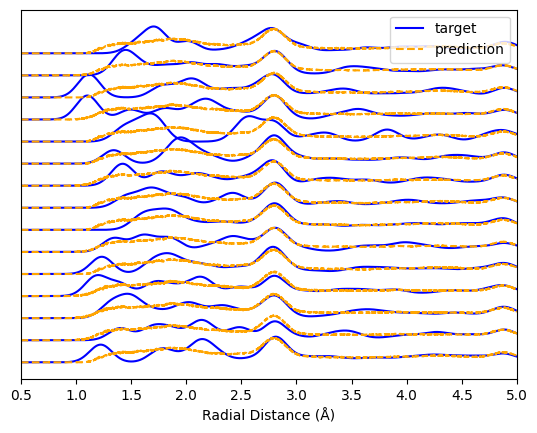

In [8]:
row = test_data.iloc[0]
target_rdf = [row[i] for i in range(1, 12000)]
predicted_rdf = [row[i] for i in range(12000, 23999)]
rs = np.arange(0.001, 12.0, 0.001)
plt.plot(rs, np.array(target_rdf), label = 'target', c = 'b')
plt.plot(rs, np.array(predicted_rdf), label = 'prediction', c = 'orange', linestyle = 'dashed')
for j in range(1,len(test_data)):
  row = test_data.iloc[j]
  target_rdf = [row[i] for i in range(1, 12000)]
  predicted_rdf = [row[i] for i in range(12000, 23999)]
  rs = np.arange(0.001, 12.0, 0.001)
  plt.plot(rs, np.array(target_rdf) + 10 * j, c = 'b')
  plt.plot(rs, np.array(predicted_rdf) + 10 * j, c = 'orange', linestyle = 'dashed')
plt.legend()
plt.xlim((0.5, 5))
plt.yticks([])
plt.xlabel("Radial Distance (Å)");

In [9]:
%cd MatDeepLearn_dev
!pip install -e .

/content/ActiveStructOpt/MatDeepLearn_dev
Obtaining file:///content/ActiveStructOpt/MatDeepLearn_dev
  Preparing metadata (setup.py) ... done
  Attempting uninstall: matdeeplearn
    Found existing installation: matdeeplearn 0.0.1
    Uninstalling matdeeplearn-0.0.1:
      Successfully uninstalled matdeeplearn-0.0.1
  Running setup.py develop for matdeeplearn


In [10]:
from torch_geometric.data import Data, DataLoader, InMemoryDataset
import matdeeplearn.models.cgcnn as CGCNN
from torch_geometric.utils import dense_to_sparse
from torch_geometric.transforms import Compose
from matdeeplearn.preprocessor.helpers import (
    clean_up,
    generate_edge_features,
    generate_node_features,
    get_cutoff_distance_matrix,
)
from matdeeplearn.common.data import get_dataloader

In [12]:
model = CGCNN.CGCNN(100, 50, 11999, dim1 = 100, dim2 = 150, gc_count = 4, post_fc_count = 3, pool = "global_mean_pool", batch_norm = True)
checkpoint = torch.load("/content/ActiveStructOpt/results/" +
                        os.listdir('/content/ActiveStructOpt/results')[0] +
                        "/checkpoint/checkpoint.pt")
model.load_state_dict(checkpoint["state_dict"])
model.eval()

CGCNN(
  (distance_expansion): GaussianSmearing()
  (pre_lin_list): ModuleList(
    (0): Linear(in_features=100, out_features=100, bias=True)
  )
  (conv_list): ModuleList(
    (0): CGConv(100, dim=50)
    (1): CGConv(100, dim=50)
    (2): CGConv(100, dim=50)
    (3): CGConv(100, dim=50)
  )
  (bn_list): ModuleList(
    (0): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (post_lin_list): ModuleList(
    (0): Linear(in_features=100, out_features=150, bias=True)
    (1): Linear(in_features=150, out_features=150, bias=True)
    (2): Linear(in_features=150, out_features=150, bias=True)
  )
  (lin_out): Linear(in_features=150, out_features=11999, bias=True)
)

In [13]:
# based on https://github.com/Fung-Lab/MatDeepLearn_dev/blob/main/matdeeplearn/preprocessor/processor.py
class OptStructure:
    def __init__(self,
                 structure,
                 device: str = "cpu",
                 r: float = 8.0,
                 n_neighbors: int = 250,
                 edge_steps: int = 50,
                ):
        self.data_list = [Data() for _ in range(1)]
        natoms = len(structure)
        numbers = [target_structure.sites[j
          ].species.elements[0].Z for j in range(natoms)]

        data = self.data_list[0]

        pos = torch.tensor([[[
            structure.sites[j].a, structure.sites[j].b, structure.sites[j].c]
            ] for j in range(natoms)], device = device, dtype = torch.float)
        cell = torch.tensor([structure.lattice.matrix], device = device,
                            dtype=torch.float)

        cd_matrix, cell_offsets, atom_rij = get_cutoff_distance_matrix(
            pos,
            cell,
            r,
            n_neighbors
        )
        edge_indices, edge_weights = dense_to_sparse(cd_matrix)
        data.n_atoms = natoms
        data.pos = pos
        data.cell = cell
        data.y = torch.Tensor(np.array([0]))
        data.z = torch.LongTensor(numbers, device = device)
        data.u = torch.Tensor(np.zeros((3))[np.newaxis, ...])
        data.edge_index, data.edge_weight = edge_indices, edge_weights
        data.cell_offsets = cell_offsets
        data.edge_descriptor = {}
        data.edge_descriptor["distance"] = edge_weights
        data.distances = edge_weights
        data.structure_id = [["_"]]

        generate_node_features(self.data_list, n_neighbors, device = device)
        generate_edge_features(self.data_list, edge_steps, r, device = device)

        self.data_list[0].x.float()

        Compose([])(self.data_list[0])

        clean_up(self.data_list, ["edge_descriptor"])

<ipython-input-13-02331740c564>:20: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  cell = torch.tensor([structure.lattice.matrix], device = device,


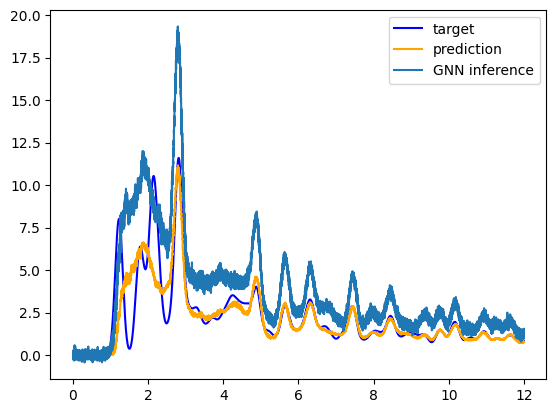

In [14]:
row = test_data.iloc[0]
target_rdf = [row[i] for i in range(1, 12000)]
predicted_rdf = [row[i] for i in range(12000, 23999)]
rs = np.arange(0.001, 12.0, 0.001)
plt.plot(rs, np.array(target_rdf), label = 'target', c = 'b')
plt.plot(rs, np.array(predicted_rdf), label = 'prediction', c = 'orange',)
plt.plot(rs, model.forward(OptStructure(initial_structures[test_data.iloc[0,0]]).data_list[0])['output'].detach().numpy().flatten(), label = 'GNN inference')
plt.legend()

(0.94, 1.0)

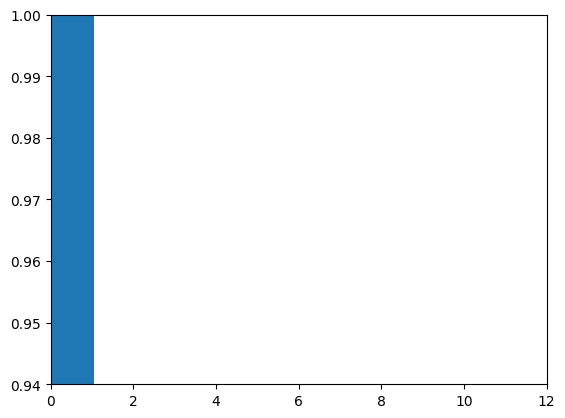

In [15]:
plt.plot(rs, model.forward(OptStructure(initial_structures[test_data.iloc[0,0]]).data_list[0])['output'].detach().numpy().flatten() / np.array(predicted_rdf))
plt.xlim([0.0, 12])
plt.ylim([0.94, 1.0])